# Profils de succion et drainage latéral dans les barrières capillaires

Pour exécuter une cellule, `Ctrl + Enter`. Pour exécuter une cellule et passer à la suivante, `Maj. + Enter`. Pour exécuter toute la feuille, dans le menu `Cell`, sélectionner `Run All`.

## Charger les librairies

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from scipy.integrate import quad
from scipy.interpolate import interp1d
pylab.rcParams['figure.figsize'] = (8.0, 6.0)

Populating the interactive namespace from numpy and matplotlib


## Modèles hydrauliques

### Courbe de rétention d'eau, van Genuchten (1980):
\begin{align}
\theta(\psi)  = \theta_{r} + (\theta_{s} - \theta_{r})  (1+(a_{VG}  \psi)^{n_{VG}})^{-m_{VG}} \\
\end{align}

### Fonction de conductivité hydraulique, van Genuchten et al. (1991), basé sur van Genuchten (1980) et Mualem (1976):
\begin{align}
k(\psi) = k_{sat}  \frac {(1-((a_{VG}  \psi)^{n_{VG}m_{VG}})  (1+(a_{VG} \psi)^{n_{VG}})^{-m_{VG}}))^2} { (1+(a_{VG} \psi)^{n_{VG}})^{m_{VG}l_{VG}}}
\end{align}

In [2]:
class VanGenuchten(object):
    """
    Returns the water retention curve and hydraulic conductivity function
    according to van Genuchten (1980)'s functions
    """
    def __init__(self, thR, thS, aVG, nVG, mVG, ksat, psi, lVG=0.5):
        self.aVG = aVG
        self.nVG = nVG
        self.mVG = mVG
        self.lVG = lVG
        self.ksat = ksat
        self.thR = thR
        self.thS = thS
        self.npoints = len(psi)
        self.psi = psi
        
    def wrc(self):
        self.th = self.thR + (self.thS - self.thR) * (1+(self.aVG * self.psi) ** self.nVG) ** (-self.mVG)
        return([self.psi, self.th])
        
    def hcf(self):
        self.k = self.ksat*((1-((self.aVG*self.psi)**(self.nVG*self.mVG))* \
        ((1+((self.aVG*self.psi)**self.nVG))**(-self.mVG)))**2) / \
        ((1+((self.aVG*self.psi)**self.nVG))**(self.mVG*self.lVG))
        return([self.psi, self.k])

## Profile de succion dans une colonne de matériau poreux soumis à un débit unitaire

Une démonstration similaire a d'abord été publiée parKisch (1959).

\begin{align}
q = k(\psi) \frac{dh}{dz} \\
h = z + p = z - \psi \\
q = k(\psi) \frac{dz - d\psi}{dz} \\
q = k(\psi) (1 - \frac{d\psi}{dz}) \\
\frac {q}{k(\psi)} = 1 - \frac{d\psi}{dz} \\
\frac{d\psi}{dz} = 1-\frac {q}{k(\psi)} \\
dz = \frac{d\psi}{1-\frac {q}{k(\psi)}} \\
z(\psi) = \int_{\psi_{min}}^{\psi} \frac{1}{1-\frac {q}{k(\psi)}}d\psi
\end{align}

L'intégrale peut être approximée par:
\begin{align}
z(\psi) = \sum_{i=1}^{n} \frac{\Delta\psi}{1-\frac {q}{k_n(\psi)}}
\end{align}

In [3]:
class VerticalFlow(object):
    """
    This class uses the vertical flow model presented by Kisch (1959).
    """
    def __init__(self, model, q, psiMin = 1e-3, zMin = 0, perc = 0.999):
        self.model = model
        self.q = q
        self.psiMin = psiMin
        self.zMin = zMin
        self.perc = perc
        
    def kisch(self):
        # suction vector
        self.psiModel = self.model.hcf()[0]
        self.kModel = self.model.hcf()[1]
        
        #Find the maximal succion that can be found in a column of a por. mat. described by model under flow q
        interpFuncModel = interp1d(np.log10(self.kModel[::-1]), np.log10(self.psiModel[::-1]))
        
        # succion varies from the minimum succion in the model to the maximal succion value psiMax by deltaPsi
        self.psiMax = 10**interpFuncModel(np.log10(self.q))
        
        # recompute the model between psiMin and psiMax
        self.psiNewMod = np.logspace(start = np.log10(self.psiMin), stop = np.log10(self.psiMax),
                                     num = self.model.npoints, endpoint = True)
        newModel = VanGenuchten(thR = self.model.thR, thS = self.model.thS, 
                                aVG = self.model.aVG, nVG = self.model.nVG, mVG = self.model.mVG, 
                                lVG = self.model.lVG, ksat = self.model.ksat, psi = self.psiNewMod)
        
        self.psiKisch = newModel.hcf()[0] # suction vector
        self.kKisch = newModel.hcf()[1] # hydraulic conductivity vector
                
        # delta psi
        self.psiKischB = np.append(self.psiMin, self.psiKisch)
        self.deltaPsiKisch = []
        for i in range(1, len(self.psiKischB)):
            d = self.psiKischB[i] - self.psiKischB[i-1]
            self.deltaPsiKisch.append(d)
        self.deltaPsiKisch = np.array(self.deltaPsiKisch)
        
        # kisch
        zPieces = self.deltaPsiKisch / (1 - self.q/self.kKisch) # pieces to sum
        self.z = []
        for i in range(0, len(self.deltaPsiKisch)):
            self.z.append(np.sum(zPieces[0:i]))
        self.z = np.array(self.z) + self.zMin     
        
        return([self.psiKisch, self.z, self.psiMax])

## Matériaux

Exécuter la cellule qui correpond à vos matériaux.

In [4]:
# CBL parameters
cblthR = 0.017
cblthS = 0.37
cblaVG = 3.07 * 9.807 # 9.807 pour convertir en en m-1
cblnVG = 3.33
cblmVG = 1 - 1/cblnVG
cbllVG = 0.5
cblksat = 2.3e-3 # m/s

# MRL parameters
mrlthR = 0.03 # 0.1 # 
mrlthS = 0.4 #0.43 # 
mrlaVG = 0.347 * 9.807 #0.14 * 9.807 # 9.807 pour convertir en en m-1
mrlnVG = 2.29 # 1.23 # 
mrlmVG = 1 - 1/mrlnVG
mrllVG = 0.5
mrlksat = 8e-5 # 1.9e-7# m/s

## Modèle d'infiltration vertical

### Créer des instances pour les deux matériaux

In [5]:
npoints = 500
psiCBL = np.logspace(start = -2, stop = 2, num = npoints, endpoint = True)
psiMRL = np.logspace(start = -2, stop = 2, num = npoints, endpoint = True)

cblModel = VanGenuchten(thR = cblthR, thS = cblthS, aVG = cblaVG, nVG = cblnVG, mVG = 1-1/cblnVG, 
                        lVG = cbllVG, ksat = cblksat, psi = psiCBL)
mrlModel = VanGenuchten(thR = mrlthR, thS = mrlthS, aVG = mrlaVG, nVG = mrlnVG, mVG = 1-1/mrlnVG, 
                        lVG = mrllVG, ksat = mrlksat, psi = psiMRL)

### Calculer le modèle de Kisch

In [6]:
unit_flow = 1e-8

# CBL profile
profileCBL = VerticalFlow(model = cblModel, q = unit_flow, psiMin = 1e-4, zMin = 0)
profileCBL.kisch()

# MRL profile
profileMRL = VerticalFlow(model = mrlModel, q = unit_flow, 
                          psiMin = np.max(profileCBL.kisch()[0]), zMin = 0.5, perc = 1)
profileMRL.kisch()

print ('La succion maximale obtenur dans la CBL pour un débit de ', unit_flow, 'm/s est de', profileCBL.psiMax, 'm.')
print ('La succion maximale obtenur dans la MRL pour un débit de ', unit_flow, 'm/s est de', profileMRL.psiMax, 'm.')

La succion maximale obtenur dans la CBL pour un débit de  1e-08 m/s est de 0.146582685679 m.
La succion maximale obtenur dans la MRL pour un débit de  1e-08 m/s est de 1.30238378993 m.


### Graphiques des fonctions hydrauliques


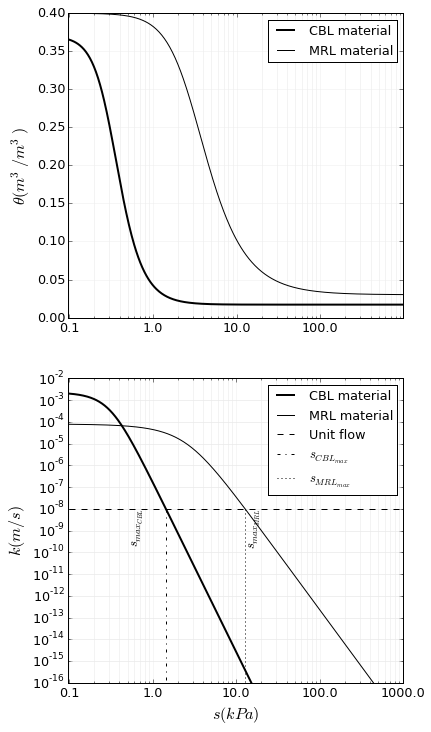

In [7]:
data = pd.DataFrame.from_items([('psi', cblModel.wrc()[0]),
                                ('theta', cblModel.wrc()[1])])
fontSize = 16
fig1, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
axes[0].set_axisbelow(True)
axes[0].tick_params(labelsize = fontSize * 0.8)
axes[0].grid(b=True, which='major', color='#eeeeee', linestyle='-')
axes[0].grid(b=True, which='minor', color='#e9e9e9', linestyle='-')
axes[0].set_ylabel(r'$\theta (m^3/m^3)$', fontsize = fontSize)
axes[0].set_xscale('log')
axes[0].set_xticks([0.1, 1, 10, 100, 1000])
axes[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axes[0].plot(cblModel.wrc()[0] * 9.807, cblModel.wrc()[1], linestyle='-', color = 'black', 
             linewidth=2, label="CBL material")
axes[0].plot(mrlModel.wrc()[0] * 9.807, mrlModel.wrc()[1], linestyle='-', color = 'black', 
             label="MRL material")
legend = axes[0].legend(fontsize = fontSize * 0.8)
frame = legend.get_frame()
frame.set_facecolor('1.00')

axes[1].set_axisbelow(True)
axes[1].tick_params(labelsize = fontSize * 0.8)
axes[1].grid(b=True, which='major', color='#eeeeee', linestyle='-')
axes[1].grid(b=True, which='minor', color='#e9e9e9', linestyle='-')
axes[1].set_xlabel(r'$s (kPa)$', fontsize = fontSize)
axes[1].set_ylabel(r'$k (m/s)$', fontsize = fontSize)
axes[1].set_xscale('log')
axes[1].set_xticks([0.1, 1, 10, 100, 1000])
axes[1].set_yscale('log')
axes[1].set_ylim([1e-16, 1e-2])
axes[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# kFn
axes[1].plot(cblModel.hcf()[0] * 9.807, cblModel.hcf()[1], linestyle='-', linewidth = 2, color = 'black', label="CBL material")
axes[1].plot(mrlModel.hcf()[0] * 9.807, mrlModel.hcf()[1], linestyle='-', color = 'black', label="MRL material")

# Model
axes[1].plot([0.1, 1000], [unit_flow, unit_flow], # profileMRL.psiMax
             linestyle='--', color = 'black', label="Unit flow") #  unit flow
axes[1].plot([profileCBL.psiMax * 9.807, profileCBL.psiMax * 9.807], [unit_flow, 1e-16],
             linestyle='-.', color = 'black', label=r'$s_{CBL_{max}}$') 
axes[1].plot([profileMRL.psiMax * 9.807, profileMRL.psiMax * 9.807], [unit_flow, 1e-16], 
             linestyle=':', color = 'black', label=r'$s_{MRL_{max}}$')
axes[1].text(profileCBL.psiMax * 9.807 - 0.9, 5e-9, r"$s_{max_{CBL}}$", 
             fontsize = fontSize * 0.8, color="black", rotation = "vertical")
axes[1].text(profileMRL.psiMax * 9.807 + 1.0, 5e-9, r"$s_{max_{MRL}}$", 
             fontsize = fontSize * 0.8, color="black", rotation = "vertical")

legend = axes[1].legend(fontsize = fontSize * 0.8)
frame = legend.get_frame()
frame.set_facecolor('1.00')
#fig1.savefig('fig1.svg') 

### Graphiques des profils

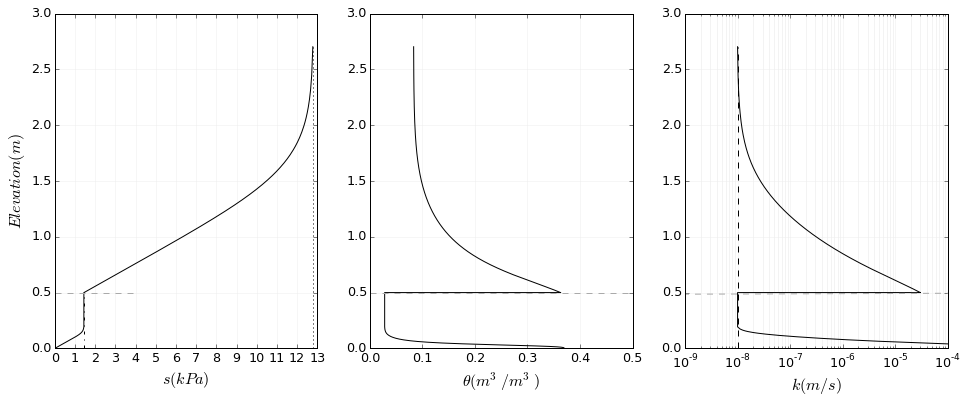

In [8]:
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

# Suction profile
axes[0].set_axisbelow(True)
axes[0].tick_params(labelsize = fontSize * 0.8)

axes[0].xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))

axes[0].grid(b=True, which='major', color='#eeeeee', linestyle='-')
axes[0].grid(b=True, which='minor', color='#e9e9e9', linestyle='-')
axes[0].set_xlabel(r'$s (kPa)$', fontsize = fontSize)
axes[0].set_ylabel(r'$Elevation (m)$', fontsize = fontSize)
axes[0].plot(np.append(profileCBL.kisch()[0], profileMRL.kisch()[0]) * 9.807,
             np.append(profileCBL.kisch()[1], profileMRL.kisch()[1]),
             linestyle='-', color = 'black')
axes[0].plot([profileCBL.psiMax * 9.807, profileCBL.psiMax * 9.807],
             [0, 0.5],
             linestyle='-.', color = 'black')
axes[0].plot([profileMRL.psiMax * 9.807,profileMRL.psiMax * 9.807],
             [0, max(profileMRL.kisch()[1])],
             linestyle=':', color = 'black')
axes[0].plot([0, 4.0], [0.5, 0.5], linestyle = "--", color = "#aaaaaa")

# Water content profile
psiInterfaceCBL = np.append(profileCBL.kisch()[0], profileCBL.psiMax)
zInterfaceCBL = np.append(profileCBL.kisch()[1], 0.49999)
cblNew = VanGenuchten(thR = cblthR, thS = cblthS, aVG = cblaVG, nVG = cblnVG, mVG = 1-1/cblnVG, 
                      lVG = cbllVG, ksat = cblksat, psi = psiInterfaceCBL)
mrlNew = VanGenuchten(thR = mrlthR, thS = mrlthS, aVG = mrlaVG, nVG = mrlnVG, mVG = 1-1/mrlnVG, 
                      lVG = mrllVG, ksat = mrlksat, psi = profileMRL.kisch()[0])

axes[1].set_axisbelow(True)
axes[1].tick_params(labelsize = fontSize * 0.8)
axes[1].grid(b=True, which='major', color='#eeeeee', linestyle='-')
axes[1].grid(b=True, which='minor', color='#e9e9e9', linestyle='-')
axes[1].set_xlabel(r'$\theta (m^3/m^3)$', fontsize = fontSize)
axes[1].plot(np.append(cblNew.wrc()[1], mrlNew.wrc()[1]),
             np.append(zInterfaceCBL, profileMRL.kisch()[1]),
             linestyle='-', color = 'black')
axes[1].plot([0, 0.5], [0.5, 0.5], linestyle = "--", color = "#aaaaaa")

# Hydraulic conductivity profile
axes[2].set_axisbelow(True)
axes[2].tick_params(labelsize = fontSize * 0.8)
axes[2].grid(b=True, which='major', color='#eeeeee', linestyle='-')
axes[2].grid(b=True, which='minor', color='#e9e9e9', linestyle='-')
axes[2].set_xlabel(r'$k (m/s)$', fontsize = fontSize)
axes[2].set_xscale('log')
axes[2].set_xlim([1e-9, 1e-4])
axes[2].plot(np.append(cblNew.hcf()[1], mrlNew.hcf()[1]),
             np.append(zInterfaceCBL, profileMRL.kisch()[1]),
             linestyle='-', color = 'black')
axes[2].plot([unit_flow, unit_flow], [0, max(profileMRL.kisch()[1])], linestyle = "--", color = "black")
axes[2].plot([0, 0.5], [1e-3, 0.5], linestyle = "--", color = "#aaaaaa")
#fig2.savefig('fig2.svg') 

## Drainage latéral dans une barrière capillaire inclinée

Ross (1990) décrit le modèle suivant.

\begin{align}
Q_{max} = \tan(\phi) \int_{\psi_{CBC}}^{\psi_{CRC}} k(\psi) d\psi \\
L = \frac {Q_{max}}{q}
\end{align}

In [9]:
def k_vanGenuchten(x, aVG, nVG, mVG, ksat, lVG = 0.5):
        k = ksat * ((1 - ((aVG * x)**(nVG * mVG)) * \
        ((1 + ((aVG * x)**nVG))**(-mVG)))**2) / \
        ((1 + ((aVG * x)**nVG))**(mVG * lVG))
        return(k)

### Épaisseur minimale de la couche de bris capillaire (CBC ou CBL)

In [10]:
profileCBL.psiMax

0.14658268567879312

### Épaisseur de la couche de rétention capillaire (CRC ou MRL)

In [11]:
pente = 0.25

# changer le multiplicateur  profileMRL.psiMax * 1 ou profileMRL.psiMax * 10 pour obtenir une plage de calcul plus large
mrlPsi = np.linspace(start = profileCBL.psiMax, stop = profileMRL.psiMax * 1, num = 50, endpoint = True) 
mrlTh = mrlPsi - profileCBL.psiMax
Qmax = []
L = []
for i in range(0, len(mrlPsi)):
    Qmax.append(pente * quad(k_vanGenuchten, profileCBL.psiMax, mrlPsi[i], args=(mrlaVG, mrlnVG, mrlmVG, mrlksat, mrllVG))[0])
    L.append(Qmax[i] / unit_flow)

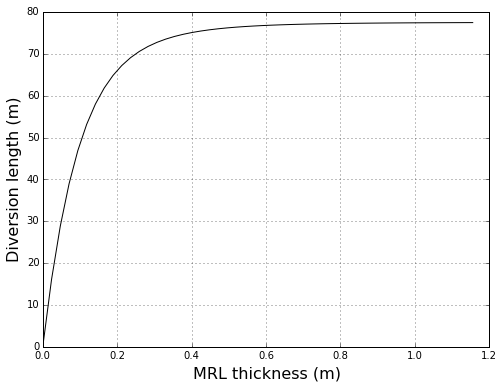

In [12]:
plot(mrlTh, L, color = 'black')
xlabel('MRL thickness (m)', fontsize = fontSize)
ylabel('Diversion length (m)', fontsize = fontSize)
grid()

In [13]:
print ('Le débit de transfert maximal dans la barrière capillaire est de', max(Qmax), 'm²/s.')
print ('La longueur de transfert maximale dans la barrière capillaire est de', max(L), 'm.')

Le débit de transfert maximal dans la barrière capillaire est de 7.746872984104624e-07 m²/s.
La longueur de transfert maximale dans la barrière capillaire est de 77.46872984104624 m.


In [14]:
pd.DataFrame(mrlTh, L)

,0
0.000000,0.000000
16.075837,0.023588
28.870588,0.047176
38.974158,0.070763
46.912306,0.094351
53.132949,0.117939
58.005202,0.141527
61.825920,0.165114
64.829704,0.188702
67.199720,0.212290
